# Importing necessary libraries


In [48]:
# Torch-related imports
from torch.utils.data import WeightedRandomSampler, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import Resize
from torchaudio.transforms import MFCC
from torch.cuda.amp import GradScaler
from torchvision import models
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler
import torchaudio.transforms as T
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchaudio
import torch

# Sklearn-related imports
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.utils.class_weight as class_weight
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics

# Audio processing imports
from pydub.silence import split_on_silence
from pydub import AudioSegment
import librosa

# Miscellaneous imports
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import wandb
import os

# Dataset, dataloader, and model parameters


In [49]:
# Set seed for reproducibility
torch.manual_seed(42)

# Path to data
# data = pd.read_csv("/kaggle/input/filtered-csv/filtered_audio_data.csv")
# data["uuid"] = data["uuid"].str.replace("../Dataset/MP3/", "/kaggle/input/covid-19-audio-classification/MP3/")
data = pd.read_csv("misc_data/filtered_audio_data.csv")

# Class labels
labels = ["healthy", "symptomatic", "COVID-19"]

# Silence arguments
min_silence = 500
threshold_dBFS = -40
keep_silence = 300

# Dataloader and dataset arguments
batch = 3
workers = 0
pin_memory = True
dataset_type = "undersampled"  # weighted or unsampled
undersampling = 500

# Settings for MelSpectrogram computation
melkwargs = {
    "n_mels": 60,  # How many mel frequency filters are used
    "n_fft": 350,  # How many fft components are used for each feature
    "win_length": 350,  # How many frames are included in each window
    "hop_length": 100,  # How many frames the window is shifted for each component
    "center": False,  # Whether frams are padded such that the component of timestep t is centered at t
    "f_max": 11000,  # Maximum frequency to consider
    "f_min": 0,
}
n_mfcc = 45
sample_rate = 22000

# Model type
"""
Models:
    "resnet18":
    "resnet34":
    "resnet50":
    "vgg_bn":
    "multi_resnet":
    "modified_multi_resnet"
    "modified_multi_resnet_spectral"
"""
model_type = "modified_multi_resnet_spectral"
model_arch = "resnet18"
model_output = "modified_multi_resnet18_spectral_undersampled"

# Model training and Weights and Biases variables
lr = 0.0001
step = 3  # steplr
decay = 0.001  # L2 regularization
gamma = 0.5  # steplr
optimizer_type = "adam"  # adam or sgd
scheduler_type = "steplr"  # stepplateau or steplr
factor = 0.1  # stepplateau
patience = 2  # stepplateau
thresh_plat = 0.001  # stepplateau
cooldown = 0  # stepplateau
epochs = 25
ID = "Simon"
runName = "Test run 1"
arch = "Multi Input ResNet18 Spectral"
desc = "This model is trained on MFCC features, numeric features, and spectral features."
dataset = "COVID-19 Audio Classification"
weighted = False

# Setup weights and biases logging


In [50]:
"""
#Initialize wandb
!wandb login --relogin 9be53a0c7076cae09612be80ee5e0e80d9dac79c

#Defining weights and biases config
wandb.init(
   # set the wandb project where this run will be logged
   project="Final-Mini-Project",
   name=runName,
   notes=desc,
   config={
   "ID": ID,
   "architecture": arch,
   "dataset": dataset,
   "learning_rate": lr,
   "step_size": step,
   "weight_decay": decay,
   "optimizer": optimizer_type,
   "scheduler": scheduler_type,
   "gamma": gamma,
   "epochs": epochs,
   "factor": factor,
   "threshold": thresh_plat,
   "patience": patience,
   "cooldown": cooldown
   }
)

"""

'\n#Initialize wandb\n!wandb login --relogin 9be53a0c7076cae09612be80ee5e0e80d9dac79c\n\n#Defining weights and biases config\nwandb.init(\n   # set the wandb project where this run will be logged\n   project="Final-Mini-Project",\n   name=runName,\n   notes=desc,\n   config={\n   "ID": ID,\n   "architecture": arch,\n   "dataset": dataset,\n   "learning_rate": lr,\n   "step_size": step,\n   "weight_decay": decay,\n   "optimizer": optimizer_type,\n   "scheduler": scheduler_type,\n   "gamma": gamma,\n   "epochs": epochs,\n   "factor": factor,\n   "threshold": thresh_plat,\n   "patience": patience,\n   "cooldown": cooldown\n   }\n)\n\n'

# Setup and define custom dataset class

The custom dataset class finds each raw audio sample and corresponding label, encodes the label and returns the raw audio sample as mono-channel as well as the label.


In [51]:
def remove_silence(audio_object, min_silence_ms=100, threshold_dBFS=-40, keep_silence=100, seek_step=1):
    # Check for loudness (DEBUGGING)
    # loudness_dBFS = audio_object.dBFS
    # print("Loudness (dBFS):", loudness_dBFS)

    # Attempt to split and remove silence from the audio signal
    audio_segments = split_on_silence(audio_object, min_silence_ms, threshold_dBFS, keep_silence, seek_step)

    # Check if audio_segments is empty if yes return the original audio object as numpy array
    if not audio_segments:

        # Get the array of samples from the audio segment
        org_audio = np.array(audio_object.get_array_of_samples(), dtype=np.float32)

        # Normalize the samples if needed
        org_audio /= np.max(np.abs(org_audio))

        return org_audio

    # Add the different audio segments together
    audio_processed = sum(audio_segments)

    # Return the samples from the processed audio, save as numpy array, and normalize it
    audio_processed = np.array(audio_processed.get_array_of_samples(), dtype=np.float32)
    audio_processed /= np.max(np.abs(audio_processed))

    return audio_processed


def encode_age(age):
    # Define age mapping
    age_mapping = {"child": 0, "teen": 1, "adult": 2, "senior": 3}

    # Determine age range
    if age <= 12:  # Children from ages 0-12
        return age_mapping["child"]
    elif age <= 19:  # Teenagers from ages 13-19
        return age_mapping["teen"]
    elif age <= 50:  # Adults from ages 20-50
        return age_mapping["adult"]
    else:  # Seniors (age > 50)
        return age_mapping["senior"]

In [52]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data, args, label_encoder=None):
        # Initialize attributes
        self.data = data["uuid"]
        self.label = data["status"]
        self.age = data["age"]
        self.gender = data["gender"]
        self.SNR = data["SNR"]
        self.label_encoder = label_encoder
        self.min_silence = args[0]
        self.threshold = args[1]
        self.keep_silence = args[2]
        self.sample_rate = {}

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Extract audio sample from idx
        audio_path = self.data[idx]

        # Load in audio
        audio_object = AudioSegment.from_file(audio_path)
        audio_sample = remove_silence(audio_object, self.min_silence, self.threshold, self.keep_silence)
        self.sample_rate[idx] = audio_object.frame_rate

        # Extract audio label from idx and transform
        audio_label = [self.label[idx]]
        audio_label = self.label_encoder.transform(audio_label)

        # Extract age, gender, and SNR from idx and encode the necessary features
        gender_mapping = {"male": 0, "female": 1}
        gender = np.array([gender_mapping[self.gender[idx]]], dtype=np.int8)
        age = np.array(encode_age(self.age[idx]), dtype=np.int8)
        snr = np.array([self.SNR[idx]])

        # Check if audio sample is stereo -> convert to mono (remove_silence already turns it into 1 channel)
        # if len(audio_sample.shape) > 1 and audio_sample.shape[1] > 1:
        # Convert stereo audio to mono
        # audio_sample = audio_sample.mean(dim=0, keepdim=True)

        return (
            torch.tensor(audio_sample, dtype=torch.float32),
            torch.tensor(audio_label, dtype=torch.int32),
            torch.tensor(gender, dtype=torch.int32),
            torch.tensor(age, dtype=torch.int32),
            torch.tensor(snr, dtype=torch.float32),
        )

    def __get_sample_rate__(self, idx):
        # If needed extract sample rate
        return self.sample_rate.get(idx)

# Custom collate function

The following collate function will take batches of raw audio samples and zero pad them to match the largest sized audio sample.


In [53]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.0)

    return batch.unsqueeze(1)  # Add channel dimension for MFCC input


def collate_fn(batch):
    # A data tuple has the form:
    # waveform, label

    # Separate audio samples and labels
    waveforms, labels, genders, ages, snrs = zip(*batch)

    # Pad the audio samples (if needed)
    # padded_waveforms = pad_sequence(waveforms)

    # Convert labels to tensor
    labels = torch.tensor(labels, dtype=torch.int32)

    # Stack numeric features into a tensor and normalize them (if needed)
    # scaler = StandardScaler()
    genders = torch.tensor(genders)
    ages = torch.tensor(ages)
    snrs = torch.tensor(snrs)
    numeric_features = torch.stack((genders, ages, snrs), dim=1)
    # numeric_features = torch.tensor(scaler.fit_transform(numeric_features))

    return waveforms, labels, numeric_features

# Miscellaneous functions

The following code block contains miscellaneous functions such as plotting of waveforms, spectograms, fbank, and preprocessing of the data.


In [54]:
def waveform_plot(signal, sr, title, threshold=None, plot=None):
    # Calculate time axis
    time = np.arange(0, len(signal)) / sr

    # Plot standard waveform
    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time, signal, color="b")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

    if plot:
        # Calculate dBFS values
        if np.any(signal != 0):
            db_signal = 20 * np.log10(np.abs(signal) / np.max(np.abs(signal)))
        else:
            db_signal = -60

        plt.subplot(3, 1, 2)
        # Plot waveform in dB scale
        plt.plot(time, db_signal, color="b")

        # Plot threshold level
        if threshold:
            plt.axhline(y=threshold, color="r", linestyle="--", label=f"{threshold} dBFS Threshold")
            plt.legend()

        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (dBFS)")
        plt.title(title)
        plt.grid(True)

        n_fft = 2048  # Length of the FFT window
        hop_length = 512  # Hop length for FFT
        S = np.abs(librosa.stft(signal.astype(float), n_fft=n_fft, hop_length=hop_length))

        # Convert amplitude to dB scale (sound pressure level)
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        # Get frequency bins corresponding to FFT
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        # Step 3: Plot the SPL values over frequency
        plt.subplot(3, 1, 3)
        plt.plot(freqs, np.mean(S_db, axis=1), color="b")
        plt.title("Sound Pressure Level (SPL) vs. Frequency")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("SPL (dB)")
        plt.grid(True)
        plt.xlim([20, 25000])  # Set frequency range for better visualization
        plt.xscale("log")  # Use log scale for frequency axis

        plt.tight_layout()
        plt.show()


# Stolen from pytorch tutorial xd
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", batch=0, idx=0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    im = ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )
    plt.colorbar(im, ax=ax, label="dB")
    # plt.close()
    #plt.savefig(f"test_outputs/batch{batch}_idx{idx}_{title}.png")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")


def preprocess_data(data_meta_path, data_dir_path, output_dir):
    # Read data file then remove every column other than the specified columns
    # Removes empty samples and filters through cough probability
    data = pd.read_csv(data_meta_path, sep=",")
    data = data[["uuid", "cough_detected", "SNR", "age", "gender", "status"]].loc[data["cough_detected"] >= 0.8].dropna().reset_index(drop=True).sort_values(by="cough_detected")
    data = data[(data["gender"] != "other")]

    # Count the occurrences of each age value
    age_counts = data["age"].value_counts()

    # Filter out ages with fewer than 100 samples
    ages_to_keep = age_counts.index[age_counts >= 100]

    # Filter the DataFrame based on the selected ages
    data = data[data["age"].isin(ages_to_keep)]

    # Check if the following MP3 with uuid exists
    mp3_data = []
    non_exist = []
    for file in data["uuid"]:
        if os.path.exists(os.path.join(data_dir_path, f"{file}.mp3")):
            mp3_data.append(os.path.join(data_dir_path, f"{file}.mp3"))
        else:
            non_exist.append(file)

    # Remove entries with missing MP3 files from the original data
    data = data[~data["uuid"].isin(non_exist)]

    # Replace the uuids with the path to uuid
    data["uuid"] = mp3_data

    # Save the data as csv
    data.to_csv(os.path.join(output_dir, "filtered_audio_data.csv"), index=False)

    print("Finished processing!")

In [55]:
"""
data_path = r"misc_data/metadata_compiled.csv"
data_dir_path = r"../Dataset/MP3/"
output_dir = r"misc_data/"
preprocess_data(data_path, data_dir_path, output_dir)
"""

'\ndata_path = r"misc_data/metadata_compiled.csv"\ndata_dir_path = r"../Dataset/MP3/"\noutput_dir = r"misc_data/"\npreprocess_data(data_path, data_dir_path, output_dir)\n'

# Dataset specific functions

The following codeblock contains functions specially related to the dataset preprocessing.


In [56]:
def preprocess_dataset(data, test_size):
    # Extract audio samples and labels
    X = data.drop(columns=["status"])
    y = data["status"]

    # Perform a stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Combine audio samples and target labels for training and validation sets
    train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

    return train_data, test_data


def weighted_sample(data):
    # Find class distribution
    class_counts = data["status"].value_counts()

    # Adjust weighting to each sample
    sample_weights = [1 / class_counts[i] for i in data["status"].values]

    return sample_weights


def undersample(data, minority_class_label, n):
    # Identify minority class
    minority_class = minority_class_label

    # Calculate desired class distribution (e.g., balanced distribution)
    desired_class_count = n  # Target number of samples for each class

    # Select subset from minority class
    undersampled_data_minority = data[data["status"] == minority_class].sample(n=desired_class_count)

    # Combine with samples from majority classes
    undersampled_data_majority = data[~(data["status"] == minority_class)]

    # Combine undersampled minority class with majority classes
    undersampled_data = pd.concat([undersampled_data_majority, undersampled_data_minority])

    # Shuffle the undersampled dataset
    undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)

    return undersampled_data


def visualize_dataset(data, normalize, title, feature="status"):
    print(f"{title} Distribution")
    print(data[feature].value_counts(normalize=normalize))
    print("Total samples", len(data))

    plt.figure(figsize=(6, 4))
    plt.title(f"Histogram of Patient Status\n- {title}")
    plt.bar(data[feature].value_counts().index, data[feature].value_counts())
    plt.xticks(rotation=20, ha="right", fontsize=8)
    plt.xlabel("Class", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.show()

# Initialization of dataset and dataset loader

This codeblock includes the initialization of the dataset as well as any processing needed, such as splitting it into training/testing datasets, as well as different sampling techniques, such as undersampling/weighted sampling.


In [57]:
def select_dataset(dataset_type="undersampled", train_data=None, val_data=None, test_data=None, args=None, batch=None, workers=None, undersampling=500):
    if dataset_type == "undersampled":
        # Prepare and create undersampled version
        undersampled_data = undersample(data, "healthy", undersampling)
        undersampled_data = undersample(undersampled_data, "symptomatic", undersampling)

        # train_undersampled_data, test_undersampled_data = preprocess_dataset(undersampled_data, 0.3) # ORIGINAL
        train_undersampled_data, val_undersampled_data = preprocess_dataset(undersampled_data, 0.3)
        val_undersampled_data, test_undersampled_data = preprocess_dataset(val_undersampled_data, 0.5)

        # Undersampled dataset
        train_dataset = AudioDataset(train_undersampled_data, args, le)
        val_dataset = AudioDataset(val_undersampled_data, args, le)
        test_dataset = AudioDataset(test_undersampled_data, args, le)

        # visualize_dataset(train_undersampled_data, False, "Train", "gender")
        # visualize_dataset(val_undersampled_data, False, "Val", "gender")

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch,
            shuffle=True,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch,
            shuffle=False,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )
        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch,
            shuffle=False,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )

        return train_dataloader, val_dataloader, test_dataloader

    elif dataset_type == "weighted":
        # Prepare and create weighted sampler
        train_sample_weights = weighted_sample(train_data)
        val_sample_weights = weighted_sample(val_data)
        test_sample_weights = weighted_sample(test_data)

        train_weighted_Sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_data), replacement=True)
        val_weighted_Sampler = WeightedRandomSampler(weights=val_sample_weights, num_samples=len(val_data), replacement=True)
        test_weighted_Sampler = WeightedRandomSampler(weights=test_sample_weights, num_samples=len(test_data), replacement=True)

        # Create dataset and dataloader instances
        train_dataset = AudioDataset(train_data, args, le)
        val_dataset = AudioDataset(val_data, args, le)
        test_dataset = AudioDataset(test_data, args, le)

        train_dataloader = DataLoader(
            train_dataset,
            sampler=train_weighted_Sampler,
            batch_size=batch,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )
        val_dataloader = DataLoader(
            val_dataset,
            sampler=val_weighted_Sampler,
            batch_size=batch,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )
        test_dataloader = DataLoader(
            test_dataset,
            sampler=test_weighted_Sampler,
            batch_size=batch,
            num_workers=workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )

        return train_dataloader, val_dataloader, test_dataloader


# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform labels into encoded form
encoded_labels = le.fit_transform(labels)

# Silence removal arguments
args = [min_silence, threshold_dBFS, keep_silence]

# Prepare standard dataset
train_data, test_data = preprocess_dataset(data, 0.3)  # First split the original dataset into 70% training
val_data, test_data = preprocess_dataset(test_data, 0.5)  # Second split the "test_data" into 50/50 validation and test (technically 15/15)

# Initialize dataloaders
train_dataloader, val_dataloader, test_dataloader = select_dataset(dataset_type, train_data, val_data, test_data, args, batch, workers, undersampling)

# MFCC feature extractor

In the following codeblock the MFCC specific parameters are defined and initialized. The codeblock also includes a function that pads the extracted MFCC features in order to pass it to the model.


In [58]:
def visualize_spectrogram(spectrogram, title):
    """
    Visualize the spectrogram.

    Args:
    - spectrogram (Tensor): Input spectrogram tensor, assumed to be in dB scale.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis")
    plt.colorbar(label="Magnitude (dB)")
    plt.xlabel("Time")
    plt.ylabel("Frequency Bin")
    plt.title(f"Spectrogram Visualization {title}")
    plt.show()


def MFCC_Features(data, specaugment=False, padding=False, normalize=False, resize=False):
    """
    Args:
    data: Input audio waveform
    max_length: Maximum length for padding
    normalize: Normalize the channel layer
    resize: Resize the spectrogram
    target_size: Target size for resizing
    """
    # Extract MFCC features
    # features = mfcc(data)
    # features = [torch.unsqueeze(mfcc(waveform), 0) for waveform in data]  # Adding channels
    # features = [torch.unsqueeze(torch.unsqueeze(mfcc(waveform), 0), 0) for waveform in data] # Adding batch size and channels

    if specaugment:
        # Extract spectrograms
        n = 400
        features = [T.Spectrogram(power=None, n_fft=n)(audio_sample) for audio_sample in data]
        #features = [T.MelSpectrogram(sample_rate=48000, normalized=True, n_fft=400, n_mels=100)(feature) for feature in data]
        #features = [mfcc(waveform) for waveform in data]
        
        for i, feature in enumerate(features):
            print(feature.shape)
            visualize_spectrogram(librosa.power_to_db(torch.abs(feature)), f"original {i}")

        # Initialize time stretching, time and frequency masking
        stretch = T.TimeStretch(n_freq=(n // 2 + 1))
        timeMask = T.TimeMasking(time_mask_param=40)
        freqMask = T.FrequencyMasking(freq_mask_param=40)
        features = [stretch(feature, 0.8) for feature in features]

        # Convert complex-valued spectrograms to real-valued tensors
        features = [torch.tensor(librosa.power_to_db(torch.abs(feature))) for feature in features]
        # for i, feature in enumerate(features):
        #    visualize_spectrogram(feature, f"stretched {i}")

        # Determine maximum duration
        max_len = max(feature.shape[1] for feature in features)
        
        # Pad each spectrogram to match the maximum duration
        features = [F.pad(feature, (0, max_len - feature.shape[1]), value=0.0) for feature in features]
        features = torch.stack(features, dim=0).unsqueeze(1)

        # Applying time stretching, time and frequency masking
        features = timeMask(features)
        features = freqMask(features)
        for i, feature in enumerate(features):
            visualize_spectrogram(feature[0], f"time/freq mask {i}")
    else:
        features = [torch.unsqueeze(mfcc(waveform), 0) for waveform in data]  # Adding channels

    # Hardcoded padding (WIP)
    if padding:
        # Determine maximum duration
        max_len = max(feature.shape[1] for feature in features)
        
        # Pad each spectrogram to match the maximum duration
        features = [F.pad(feature, (0, max_len - feature.shape[1]), value=0.0) for feature in features]
        #features = pad_sequence(features, batch_first=True, padding_value=0.0)
        # features = F.pad(features, (0, padding - features.shape[3]), "constant", 0)

    # Normalize the features for each sample
    if normalize == True:
        # for j, feature in enumerate(features):
        #    mean = feature.mean(dim=[1, 2], keepdim=True)
        #    std = feature.std(dim=[1, 2], keepdim=True)
        #    features[j] = (feature - mean) / std

        mean = torch.mean(features, dim=0)
        std = torch.std(features, dim=0)
        features = F.normalize(features, mean=mean, std=std)
        visualize_spectrogram(features[0], "After normalization")

    # Resize mel spectrograms
    if resize == True:
        features = [Resize((224, 1500), antialias=True)(feature) for feature in features]

        # Stack each feature as [batch_size, channels, features, length]
        features = torch.stack(features)

    return features


# Instantiate MFCC feature extractor
mfcc = MFCC(n_mfcc=n_mfcc, sample_rate=sample_rate, melkwargs=melkwargs)

# Spectral features extraction


In [59]:
def spectral_centroid(S=None, sr=22050, nfft=2048, h_length=512):
    return librosa.feature.spectral_centroid(S=S, sr=sr, n_fft=nfft, hop_length=h_length)[0]


def root_mean_square(S=None, f_length=2048, h_length=512):
    return librosa.feature.rms(S=S, frame_length=f_length, hop_length=h_length)[0]


def zero_crossing_rate(signal, f_length=2048, h_length=512):
    return librosa.feature.zero_crossing_rate(y=signal, frame_length=f_length, hop_length=h_length)[0]


def dynamic_parameters(audio_sample, sr=48000):
    duration_seconds = len(audio_sample) / sr

    if duration_seconds <= 0.5:  # Very short audio (less than 0.5 seconds)
        n_fft = 256
        hop_length = 64
        frame_length = 256
    elif 0.5 < duration_seconds <= 1:  # Short audio (0.5 - 1 second)
        n_fft = 1024
        hop_length = 256
        frame_length = 1024
    elif 1 < duration_seconds <= 5:  # Medium-length audio (1-5 seconds)
        n_fft = 2048
        hop_length = 512
        frame_length = 2048
    else:  # Long audio (longer than 5 seconds)
        n_fft = 4096
        hop_length = 1024
        frame_length = 4096
    return n_fft, hop_length, frame_length


def plot_spectral_features(ZCR, RMS, SC, STFT=None, sample_rate=48000, hop_length=None, title=None):
    # Plot STFT spectrogram
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(STFT), ref=np.max), sr=sample_rate, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"{title} STFT Spectrogram")

    # Plot ZCR
    plt.figure(figsize=(10, 6))
    plt.subplot(4, 1, 2)
    plt.plot(ZCR, color="blue")
    plt.title("Zero Crossing Rate (ZCR)")
    plt.xlabel("Time")
    plt.ylabel("ZCR Value")

    # Plot RMS
    plt.subplot(4, 1, 3)
    plt.plot(RMS, color="red")
    plt.title("Root Mean Square (RMS)")
    plt.xlabel("Time")
    plt.ylabel("RMS Value")

    # Plot SC
    plt.subplot(4, 1, 4)
    plt.plot(SC, color="green")
    plt.title("Spectral Centroid (SC)")
    plt.xlabel("Time")
    plt.ylabel("SC Value")

    plt.tight_layout()
    plt.show()


def spectral_features(y, spectral=False):
    ZCR_features = []
    RMS_features = []
    SC_features = []
    STFT_features = []
    for sample in y:
        sample = np.asarray(sample)

        # Return n_fft, hop_length, frame_length based on length of sample
        n_fft, hop_length, frame_length = dynamic_parameters(sample)

        # Compute magnitude spectrum of sample
        STFT = librosa.stft(y=sample, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window="hann", center=True, pad_mode="constant")
        S, _ = librosa.magphase(STFT)

        # Compute ZCR, RMS, and SC for additional feature extraction
        ZCR = zero_crossing_rate(signal=sample, f_length=frame_length, h_length=hop_length)
        RMS = root_mean_square(S=S, f_length=frame_length, h_length=hop_length)
        SC = spectral_centroid(S=S, sr=48000, nfft=n_fft, h_length=hop_length)

        # Convert into tensors and normalize
        ZCR = torch.tensor(ZCR, dtype=torch.float32)
        RMS = torch.tensor(RMS, dtype=torch.float32)
        SC = torch.tensor(SC, dtype=torch.float32)
        ZCR = (ZCR - ZCR.mean()) / ZCR.std()
        RMS = (RMS - RMS.mean()) / RMS.std()
        SC = (SC - SC.mean()) / SC.std()
        STFT = (STFT - STFT.mean()) / STFT.std()

        # Convert STFT into spectrogram
        STFT = torch.tensor(librosa.amplitude_to_db(np.abs(STFT), ref=np.max), dtype=torch.float32).unsqueeze(0)

        # Append the features for the current signal to the respective lists
        ZCR_features.append(ZCR)
        RMS_features.append(RMS)
        SC_features.append(SC)
        if spectral:
            STFT_features.append(STFT)

    # Compute the maximum length of features the combined features
    max_len = max(max((len(zcr), len(rms), len(sc))) for zcr, rms, sc in zip(ZCR_features, RMS_features, SC_features))
    if spectral:
        STFT_len_dim1 = max(stft.shape[1] for stft in STFT_features)
        STFT_len_dim2 = max(stft.shape[2] for stft in STFT_features)

    # Pad each feature vector to the max length and resize the STFT spectrograms
    ZCR_features = [F.pad(zcr, (0, max_len - zcr.shape[0]), value=0.0) for zcr in ZCR_features]
    RMS_features = [F.pad(rms, (0, max_len - rms.shape[0]), value=0.0) for rms in RMS_features]
    SC_features = [F.pad(sc, (0, max_len - sc.shape[0]), value=0.0) for sc in SC_features]
    if spectral:
        # STFT_features = [Resize((STFT_len_dim1, STFT_len_dim2), antialias=True)(STFT) for STFT in STFT_features] # Original
        STFT_features = [Resize((500, 300), antialias=True)(STFT) for STFT in STFT_features]

    # Stack each list of tensors to create new shape:
    # [batch_size, channels, feature_length]
    ZCR_features = torch.stack(ZCR_features, dim=0).unsqueeze(1)
    RMS_features = torch.stack(RMS_features, dim=0).unsqueeze(1)
    SC_features = torch.stack(SC_features, dim=0).unsqueeze(1)
    if spectral:
        STFT_features = torch.stack(STFT_features, dim=0)

    return ZCR_features, RMS_features, SC_features, STFT_features

  0%|          | 0/346 [00:00<?, ?it/s]

zcr batch torch.Size([3, 1, 421])
rms batch torch.Size([3, 1, 421])
sc batch torch.Size([3, 1, 421])
plotting


<Figure size 1200x800 with 0 Axes>

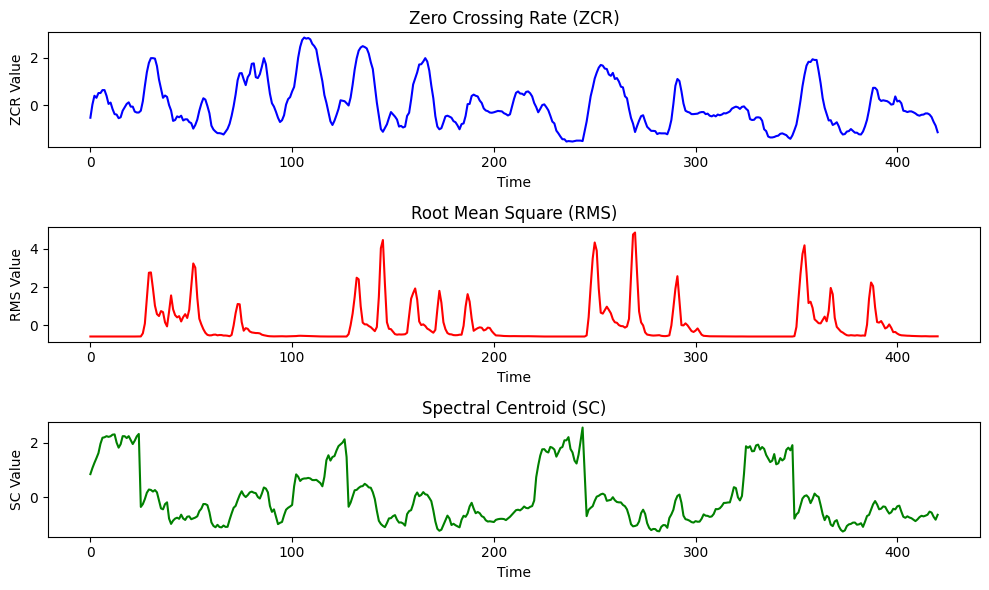

plotting


<Figure size 1200x800 with 0 Axes>

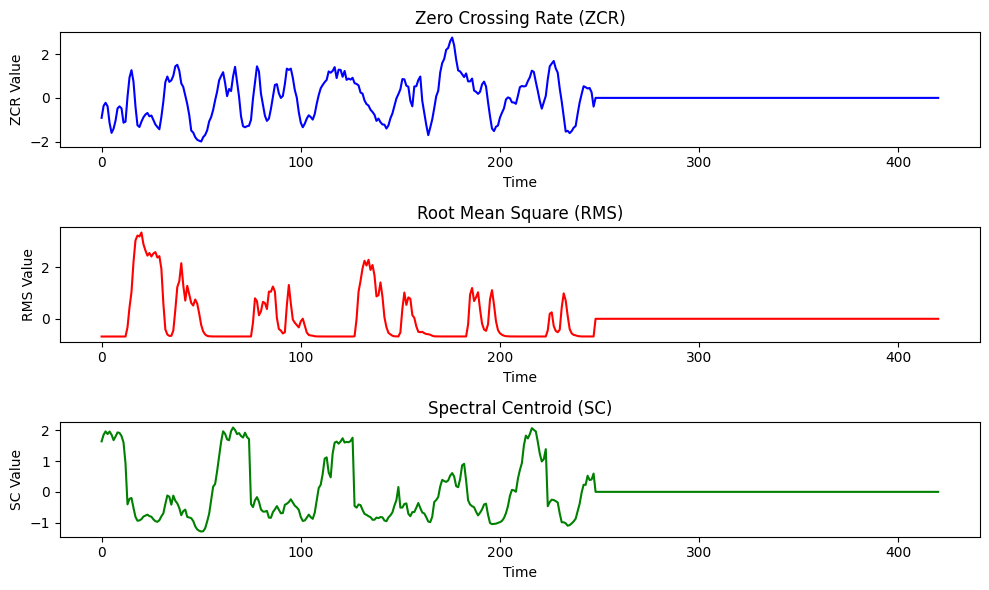

plotting


<Figure size 1200x800 with 0 Axes>

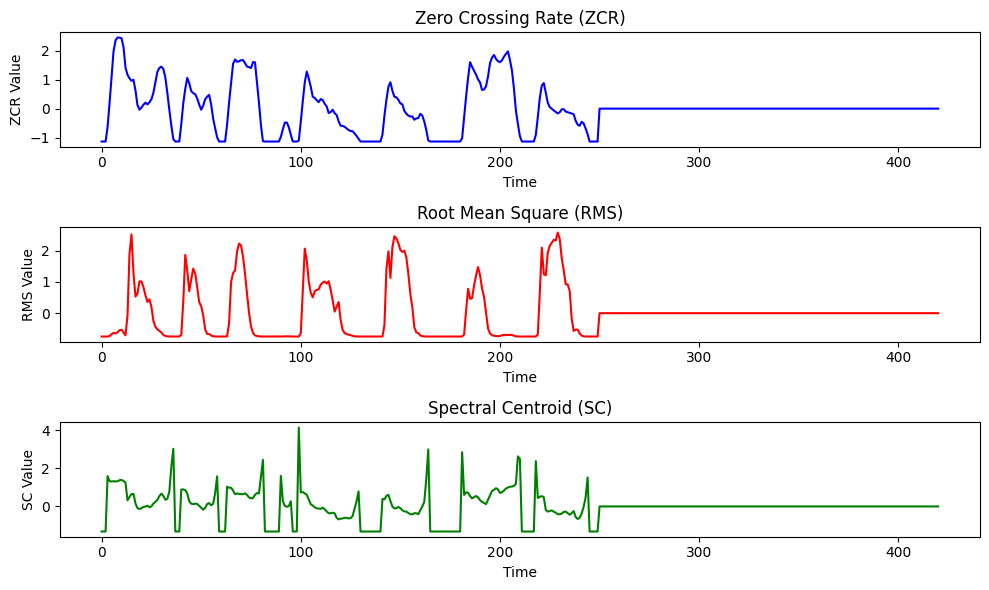

  0%|          | 0/346 [00:03<?, ?it/s]


In [60]:

for i, (inputs, targets, numeric) in tqdm(
    enumerate(train_dataloader),
    total=len(train_dataloader),
    leave=True):
    # Convert features and target labels into long
    ZCR, RMS, SC, STFT = spectral_features(inputs)
    print("zcr batch", ZCR.shape)
    print("rms batch", RMS.shape)
    print("sc batch", SC.shape)
    #print("stft batch", STFT.shape)
    for zcr,rms,sc in zip(ZCR, RMS, SC):
        
        print("plotting")
        # Plot STFT spectrogram
        plt.figure(figsize=(12, 8))

        #plt.subplot(4, 1, 1)
        #plt.imshow(np.array(STFT.squeeze(0)), aspect='auto', origin='lower')
        #plt.colorbar(format='%+2.0f dB')
        #plt.xlabel('Time (s)')
        #plt.ylabel('Frequency (Hz)')
        #plt.title('STFT Spectrogram')

        # Plot ZCR
        plt.figure(figsize=(10, 6))
        plt.subplot(3, 1, 1)
        plt.plot(np.array(zcr[0]), color='blue')
        plt.title('Zero Crossing Rate (ZCR)')
        plt.xlabel('Time')
        plt.ylabel('ZCR Value')

        # Plot RMS
        plt.subplot(3, 1, 2)
        plt.plot(np.array(rms[0]), color='red')
        plt.title('Root Mean Square (RMS)')
        plt.xlabel('Time')
        plt.ylabel('RMS Value')

        # Plot SC
        plt.subplot(3, 1, 3)
        plt.plot(np.array(sc[0]), color='green')
        plt.title('Spectral Centroid (SC)')
        plt.xlabel('Time')
        plt.ylabel('SC Value')

        plt.tight_layout()
        plt.show()

    
    if i == 0: break
    
    

# Network architectures


In [61]:
class MultiInputResNet(nn.Module):
    def __init__(self, weights=None, num_classes=3, model_arch="resnet18"):
        super(MultiInputResNet, self).__init__()
        if model_arch == "resnet18":
            self.resnet = models.resnet18(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet34":
            self.resnet = models.resnet34(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet50":
            self.resnet = models.resnet50(weights=weights, num_classes=num_classes)

        # Adjust the first convolutional layer to match number of channels
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Add additional branch to handle numeric features
        self.numeric_features = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(64, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
        )

        # Adding a fully connected layer
        self.fc = nn.Linear(512 + 3, num_classes)  # 512 from ResNet + 3 from numeric features

    def forward(self, mfcc, numeric):
        # Process MFCC input through ResNet
        mfcc_resnet_output = self.resnet(mfcc)

        # Process numeric features through additional branch
        numeric_output = self.numeric_features(numeric)

        # Concatenate the outputs from both branches
        combined_features = torch.cat((mfcc_resnet_output, numeric_output), dim=1)

        # return raw scores/logits
        output = self.fc(combined_features)

        # Apply softmax activation to get probabilities
        # output_probs = F.softmax(output, dim=1)

        return output

In [62]:
class Modified_MultiInputResNet(nn.Module):
    def __init__(self, weights=None, num_classes=3, model_arch="resnet18"):
        super(Modified_MultiInputResNet, self).__init__()
        if model_arch == "resnet18":
            self.resnet = models.resnet18(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet34":
            self.resnet = models.resnet34(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet50":
            self.resnet = models.resnet50(weights=weights, num_classes=num_classes)

        # Adjust the first convolutional layer to match number of channels
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Add additional branch to handle numeric features
        self.numeric_features = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(64, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
        )

        # Adding a fully connected layer
        self.fc = nn.Linear(512 + 3, num_classes)  # 512 from ResNet + 3 from numeric features

        # Adding fully connected layers for age and gender prediction
        self.fc_age = nn.Linear(3, 4)
        self.fc_gender = nn.Linear(3, 2)

    def forward(self, mfcc, numeric):
        # Process MFCC input through ResNet
        mfcc_resnet_output = self.resnet(mfcc)

        # Process numeric features through additional branch
        numeric_output = self.numeric_features(numeric)
        numeric_output2 = F.relu(numeric)

        # Concatenate the outputs from both branches
        combined_features = torch.cat((mfcc_resnet_output, numeric_output), dim=1)

        output_class = self.fc(combined_features)
        output_age = self.fc_age(numeric_output2)
        output_gender = self.fc_gender(numeric_output2)

        ## Apply softmax activation to get probabilities
        # output_probs_class = F.softmax(output_class, dim=1)
        # output_probs_age = F.softmax(output_age, dim=1)
        # output_probs_gender = F.softmax(output_gender, dim=1)

        return output_class, output_age, output_gender

In [63]:
class MultiInputResNet_spectral(nn.Module):
    def __init__(self, weights=None, num_classes=3, model_arch="resnet18"):
        super(MultiInputResNet_spectral, self).__init__()
        if model_arch == "resnet18":
            self.resnet = models.resnet18(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet34":
            self.resnet = models.resnet34(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet50":
            self.resnet = models.resnet50(weights=weights, num_classes=num_classes)

        # Adjust the first convolutional layer to match number of channels
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Modify final fully connected layer to output relevant features
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)

        # Add additional branch to handle numeric features
        self.numeric_features = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        # Add additional branch to handle spectral features
        self.spectral_features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.MaxPool1d(kernel_size=2), 
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, 128)
        )

        # Adding a fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(992, 512),  # 512 from Resnet, 3x512 from numeric features, and 3*512 from spectral features
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

        self.fc_stft = nn.Sequential(
            nn.Linear(4096, 3000), 
            nn.ReLU(), 
            nn.Dropout(0.1), 
            nn.Linear(3000, 2500), 
            nn.ReLU(), 
            nn.Dropout(0.2), 
            nn.Linear(2500, num_classes))  # STFT

        # Adding fully connected layers for age and gender prediction
        self.fc_age = nn.Sequential(
            nn.Linear(992, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 4),
        )

        self.fc_gender = nn.Sequential(
            nn.Linear(992, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.Linear(64, 2),
        )

    def forward(self, mfcc, numeric, ZCR, RMS, SC, STFT=None):
        # Process MFCC input through ResNet
        mfcc_resnet_output = self.resnet(mfcc)

        # Process STFT input through ResNet
        if STFT:
            stft_resnet_output = self.resnet(STFT)

        # Process numeric features through the additional branch
        gender_output = self.numeric_features(numeric[:, 0].unsqueeze(1))
        age_output = self.numeric_features(numeric[:, 1].unsqueeze(1))
        SNR_output = self.numeric_features(numeric[:, 2].unsqueeze(1))

        # Process each spectral features through the additional branch
        ZCR_output = self.spectral_features(ZCR).squeeze(dim=-1)
        RMS_output = self.spectral_features(RMS).squeeze(dim=-1)
        SC_output = self.spectral_features(SC).squeeze(dim=-1)

        # Combine the features
        if STFT:
            combined_features = torch.cat((mfcc_resnet_output, stft_resnet_output, gender_output, age_output, SNR_output, ZCR_output, RMS_output, SC_output), dim=1)
        else:
            combined_features = torch.cat((mfcc_resnet_output, gender_output, age_output, SNR_output, ZCR_output, RMS_output, SC_output), dim=1)

        # Classification output
        if STFT:
            output_class = self.fc_stft(combined_features)
        else:
            output_class = self.fc(combined_features)

        # Age and gender predictions
        output_age = self.fc_age(combined_features)
        output_gender = self.fc_gender(combined_features)

        return output_class, output_age, output_gender

In [64]:
class MultiInputResNet_spectral_2(nn.Module):
    def __init__(self, weights=None, num_classes=3, model_arch="resnet18"):
        super(MultiInputResNet_spectral, self).__init__()
        if model_arch == "resnet18":
            self.resnet = models.resnet18(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet34":
            self.resnet = models.resnet34(weights=weights, num_classes=num_classes)
        elif model_arch == "resnet50":
            self.resnet = models.resnet50(weights=weights, num_classes=num_classes)

        # Adjust the first convolutional layer to match number of channels
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Modify final fully connected layer to output relevant features
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        
        # Add additional branch to handle numeric features
        self.numeric_features = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(inplace=False),
            nn.Dropout(0.5),
            nn.Linear(64, 512),
            nn.ReLU(inplace=False),
            #nn.Dropout(0.5),
        )

        # Add additional branch to handle spectral features
        self.spectral_features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False), 
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False), 
            nn.MaxPool1d(kernel_size=2), 
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False), 
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False), 
            nn.AdaptiveAvgPool1d(1)
        )

        # Adding a fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(3584, 3000),   # 512 from Resnet, 3x512 from numeric features, and 3*512 from spectral features
            nn.ReLU(), 
            nn.Dropout(0.1),
            nn.Linear(3000, 2500),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(2500, 1500),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.Linear(1500, 1000),
            #nn.ReLU(),
            #nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2500, num_classes)
        )
        
        self.fc_stft = nn.Sequential(
            nn.Linear(4096, 3000), # STFT
            nn.ReLU(), 
            nn.Dropout(0.1),
            nn.Linear(3000, 2500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2500, num_classes)
        )
        
        # Adding fully connected layers for age and gender prediction
        self.fc_age = nn.Sequential(
            nn.Linear(3584, 1792), # original
            #nn.Linear(4096, 1792),
            nn.Dropout(0.1),
            nn.Linear(1792, 896),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(896, 448),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(448, 224),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(224, 112),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(112, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 4)
        )

        self.fc_gender = nn.Sequential(
            nn.Linear(3584, 1792), # original
            #nn.Linear(4096, 1792),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(1792, 896),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(896, 448),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(448, 224),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(224, 112),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(112, 64),
            nn.Sigmoid(),
            nn.Linear(64, 2)
        )

    def forward(self, mfcc, numeric, ZCR, RMS, SC, STFT=None):
        # Process MFCC input through ResNet
        mfcc_resnet_output = self.resnet(mfcc)
        
        # Process STFT input through ResNet
        if STFT:
            stft_resnet_output = self.resnet(STFT)

        # Process numeric features through the additional branch
        gender_output = self.numeric_features(numeric[:, 0].unsqueeze(1))
        age_output = self.numeric_features(numeric[:, 1].unsqueeze(1))
        SNR_output = self.numeric_features(numeric[:, 2].unsqueeze(1))

        # Process each spectral features through the additional branch
        ZCR_output = self.spectral_features(ZCR).squeeze(dim=2)
        RMS_output = self.spectral_features(RMS).squeeze(dim=2)
        SC_output = self.spectral_features(SC).squeeze(dim=2)
        
        # Combine the features
        if STFT:
            combined_features = torch.cat((mfcc_resnet_output,stft_resnet_output, gender_output, age_output, SNR_output, ZCR_output, RMS_output, SC_output), dim=1)
        else:
            combined_features = torch.cat((mfcc_resnet_output, gender_output, age_output, SNR_output, ZCR_output, RMS_output, SC_output), dim=1)
        
        # Classification output
        if STFT:
            output_class = self.fc_stft(combined_features)
        else:
            output_class = self.fc(combined_features)
            
        
        # Age and gender predictions
        output_age = self.fc_age(combined_features)
        output_gender = self.fc_gender(combined_features)
        
        return output_class, output_age, output_gender


# Training and validation functions


In [65]:
def initialize_training_setup(model, optimizer_type, scheduler_type, weighted=False, device=None):
    scheduler = None
    criterion2 = None
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

    elif optimizer_type == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=decay)

    # Compute class weights for loss function (if using weighted)
    if weighted == True:
        train_labels = train_data["status"]
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
        class_weights = torch.tensor(class_weights, dtype=torch.float32)
        print("COVID-19", "Healthy", "Symptomatic")
        print(class_weights)
        class_weights = class_weights.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        criterion2 = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    if scheduler_type == "steplr":
        scheduler = StepLR(optimizer, step_size=step, gamma=gamma)

    elif scheduler_type == "stepplateau":
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=factor, patience=patience, threshold=thresh_plat, cooldown=cooldown, min_lr=0)

    return optimizer, criterion, scheduler, criterion2


def train_epoch_weighted(model, device, epoch, optimizer, criterion, criterion2):
    model.train()
    running_loss = 0.0
    correct_predictions_class = 0
    correct_predictions_age = 0
    correct_predictions_gender = 0
    total_predictions_class = 0
    total_predictions_age = 0
    total_predictions_gender = 0

    print("Currently: Training")
    for i, (inputs, targets, numeric) in tqdm(
        enumerate(train_dataloader),
        total=len(train_dataloader),
        leave=True,
        desc=f"Epoch {epoch+1}/{epochs} | Training",
    ):
        # Convert features and target labels into long
        class_targets = torch.round(targets).to(torch.long)
        gender_targets = torch.round(numeric[:, 0]).to(torch.long)
        age_targets = torch.round(numeric[:, 1]).to(torch.long)

        # Load them onto GPU
        class_targets = class_targets.to(device)
        gender_targets = gender_targets.to(device)
        age_targets = age_targets.to(device)

        # Extract features
        features = MFCC_Features(inputs, padding=False, normalize=True, resize=True)  # Compute the MFCC features
        # ZCR, RMS, SC, STFT = spectral_features(inputs) # Compute spectral features
        ZCR, RMS, SC, _ = spectral_features(inputs)  # Compute spectral features
        features, numeric = features.to(device), numeric.to(device)  # Load them onto GPU
        # ZCR, RMS, SC, STFT = ZCR.to(device), RMS.to(device), SC.to(device), STFT.to(device)
        ZCR, RMS, SC = ZCR.to(device), RMS.to(device), SC.to(device)

        # Training loop
        optimizer.zero_grad()  # Zero the parameters
        # output_class, output_age, output_gender = model(features, numeric, ZCR, RMS, SC, STFT)  # Retrieve the output from the model
        output_class, output_age, output_gender = model(features, numeric, ZCR, RMS, SC)  # Retrieve the output from the model

        # Compute the loss for each output separately
        loss_class = criterion2(output_class, class_targets)
        loss_gender = criterion(output_gender, gender_targets)
        loss_age = criterion(output_age, age_targets)

        # Compute total loss - add weights to mitigate the avg high training loss
        total_loss = (1.0 * loss_class) + (0.1 * loss_age) + (0.1 * loss_gender)
        total_loss.backward()  # Compute gradients of the loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients
        optimizer.step()  # Update weights

        running_loss += total_loss.item()

        # Compute correct predictions and update statistics for class prediction
        _, predicted_class = torch.max(output_class, 1)
        correct_predictions_class += (predicted_class == class_targets).sum().item()
        total_predictions_class += class_targets.size(0)

        # Compute correct predictions and update statistics for age prediction
        _, predicted_age = torch.max(output_age, 1)
        correct_predictions_age += (predicted_age == age_targets).sum().item()
        total_predictions_age += age_targets.size(0)

        # Compute correct predictions and update statistics for gender prediction
        _, predicted_gender = torch.max(output_gender, 1)
        correct_predictions_gender += (predicted_gender == gender_targets).sum().item()
        total_predictions_gender += gender_targets.size(0)

        # Print statistics for every 5th mini-batch
        if i % 5 == 4:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i+1}/{len(train_dataloader)} | Total Training Loss: {total_loss.item():.4f}")
            print(f"Class Training Loss: {loss_class:.4f} | Gender Training Loss: {loss_gender:.4f} | Age Training Loss: {loss_age:.4f}")

    # Compute and return average training loss and accuracy for the epoch
    avg_loss = running_loss / len(train_dataloader)
    avg_accuracy_class = correct_predictions_class / total_predictions_class
    avg_accuracy_age = correct_predictions_age / total_predictions_age
    avg_accuracy_gender = correct_predictions_gender / total_predictions_gender
    print()
    print("=========================================================")
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Avg Training loss: {avg_loss:.4f}")
    print(f"Avg Training Accuracy Class: {avg_accuracy_class:.4f}")
    print(f"Avg Training Accuracy Age: {avg_accuracy_age:.4f}")
    print(f"Avg Training Accuracy Gender: {avg_accuracy_gender:.4f}")
    print("=========================================================")
    print()

    return avg_loss, avg_accuracy_class, avg_accuracy_age, avg_accuracy_gender


def train_epoch_undersampled(model, device, epoch, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_predictions_class = 0
    correct_predictions_age = 0
    correct_predictions_gender = 0
    total_predictions_class = 0
    total_predictions_age = 0
    total_predictions_gender = 0

    print("Currently: Training")
    for i, (inputs, targets, numeric) in tqdm(
        enumerate(train_dataloader),
        total=len(train_dataloader),
        leave=True,
        desc=f"Epoch {epoch+1}/{epochs} | Training",
    ):
        # Convert features and target labels into long
        class_targets = torch.round(targets).to(torch.long)
        gender_targets = torch.round(numeric[:, 0]).to(torch.long)
        age_targets = torch.round(numeric[:, 1]).to(torch.long)

        # Load them onto GPU
        class_targets = class_targets.to(device)
        gender_targets = gender_targets.to(device)
        age_targets = age_targets.to(device)

        # Extract features
        features = MFCC_Features(inputs, specaugment=True, padding=False, normalize=False, resize=False)  # Compute the MFCC features
        ZCR, RMS, SC, _ = spectral_features(inputs)  # Compute spectral features
        features, numeric = features.to(device), numeric.to(device)  # Load them onto GPU
        # ZCR, RMS, SC, STFT = ZCR.to(device), RMS.to(device), SC.to(device), STFT.to(device) # STFT
        ZCR, RMS, SC = ZCR.to(device), RMS.to(device), SC.to(device)

        # Training loop
        optimizer.zero_grad()  # Zero the parameters
        # output_class, output_age, output_gender = model(features, numeric, ZCR, RMS, SC, STFT)  # Retrieve the output from the model
        output_class, output_age, output_gender = model(features, numeric, ZCR, RMS, SC)  # Retrieve the output from the model

        # Compute the loss for each output separately
        loss_class = criterion(output_class, class_targets)
        loss_gender = criterion(output_gender, gender_targets)
        loss_age = criterion(output_age, age_targets)

        # Compute total loss - add weights to mitigate the avg high training loss
        total_loss = (1.0 * loss_class) + (0.1 * loss_age) + (0.1 * loss_gender)
        total_loss.backward()  # Compute gradients of the loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients
        optimizer.step()  # Update weights

        running_loss += total_loss.item()

        # Compute correct predictions and update statistics for class prediction
        _, predicted_class = torch.max(output_class, 1)
        correct_predictions_class += (predicted_class == class_targets).sum().item()
        total_predictions_class += class_targets.size(0)

        # Compute correct predictions and update statistics for age prediction
        _, predicted_age = torch.max(output_age, 1)
        correct_predictions_age += (predicted_age == age_targets).sum().item()
        total_predictions_age += age_targets.size(0)

        # Compute correct predictions and update statistics for gender prediction
        _, predicted_gender = torch.max(output_gender, 1)
        correct_predictions_gender += (predicted_gender == gender_targets).sum().item()
        total_predictions_gender += gender_targets.size(0)

        # Print statistics for every 5th mini-batch
        if i % 5 == 4:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i+1}/{len(train_dataloader)} | Total Training Loss: {total_loss.item():.4f}")
            print(f"Class Training Loss: {loss_class:.4f} | Gender Training Loss: {loss_gender:.4f} | Age Training Loss: {loss_age:.4f}")

    # Compute and return average training loss and accuracy for the epoch
    avg_loss = running_loss / len(train_dataloader)
    avg_accuracy_class = correct_predictions_class / total_predictions_class
    avg_accuracy_age = correct_predictions_age / total_predictions_age
    avg_accuracy_gender = correct_predictions_gender / total_predictions_gender
    print()
    print("=========================================================")
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Avg Training loss: {avg_loss:.4f}")
    print(f"Avg Training Accuracy Class: {avg_accuracy_class:.4f}")
    print(f"Avg Training Accuracy Age: {avg_accuracy_age:.4f}")
    print(f"Avg Training Accuracy Gender: {avg_accuracy_gender:.4f}")
    print("=========================================================")
    print()

    return avg_loss, avg_accuracy_class, avg_accuracy_age, avg_accuracy_gender


def validate_epoch(model, device, epoch, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions_class = 0
    correct_predictions_age = 0
    correct_predictions_gender = 0
    total_predictions_class = 0
    total_predictions_age = 0
    total_predictions_gender = 0

    precision_class = 0.0
    precision_gender = 0.0
    precision_age = 0.0
    recall_class = 0.0
    recall_gender = 0.0
    recall_age = 0.0
    f1_class = 0.0
    f1_gender = 0.0
    f1_age = 0.0

    print("Currently: Validating")
    for j, (vinputs, vtargets, vnumeric) in tqdm(
        enumerate(val_dataloader),
        total=len(val_dataloader),
        leave=True,
        desc=f"Epoch {epoch+1}/{epochs} | Validating",
    ):
        # Convert features and target labels into long
        class_targets = torch.round(vtargets).to(torch.long)
        gender_targets = torch.round(vnumeric[:, 0]).to(torch.long)
        age_targets = torch.round(vnumeric[:, 1]).to(torch.long)

        # Load them onto GPU
        class_targets = class_targets.to(device)
        gender_targets = gender_targets.to(device)
        age_targets = age_targets.to(device)

        # Extract features
        vfeatures = MFCC_Features(vinputs, padding=False, normalize=True, resize=True)  # Compute the MFCC features
        # ZCR, RMS, SC, STFT = spectral_features(vinputs)
        ZCR, RMS, SC, _ = spectral_features(vinputs)
        vfeatures, vnumeric = vfeatures.to(device), vnumeric.to(device)  # Load them onto GPU
        # ZCR, RMS, SC, STFT = ZCR.to(device), RMS.to(device), SC.to(device), STFT.to(device)
        ZCR, RMS, SC = ZCR.to(device), RMS.to(device), SC.to(device)

        # Validation loop
        # voutput_class, voutput_age, voutput_gender = model(vfeatures, vnumeric, ZCR, RMS, SC, STFT) # STFT
        voutput_class, voutput_age, voutput_gender = model(vfeatures, vnumeric, ZCR, RMS, SC)  # STFT

        # Compute the loss for each output separately
        vloss_class = criterion(voutput_class, class_targets)
        vloss_gender = criterion(voutput_gender, gender_targets)
        vloss_age = criterion(voutput_age, age_targets)

        # Compute total loss - add weights to mitigate the avg high training loss
        total_loss = (1.0 * vloss_class) + (0.1 * vloss_age) + (0.1 * vloss_gender)
        running_loss += total_loss.item()

        # Compute correct predictions and update statistics for class prediction
        _, predicted_class = torch.max(voutput_class, 1)
        correct_predictions_class += (predicted_class == class_targets).sum().item()
        total_predictions_class += class_targets.size(0)

        # Compute correct predictions and update statistics for age prediction
        _, predicted_age = torch.max(voutput_age, 1)
        correct_predictions_age += (predicted_age == age_targets).sum().item()
        total_predictions_age += age_targets.size(0)

        # Compute correct predictions and update statistics for gender prediction
        _, predicted_gender = torch.max(voutput_gender, 1)
        correct_predictions_gender += (predicted_gender == gender_targets).sum().item()
        total_predictions_gender += gender_targets.size(0)

        # Compute precision, recall, F1 score
        precision_class += precision_score(class_targets.cpu(), predicted_class.cpu(), average="macro", zero_division=0.0)
        precision_gender += precision_score(gender_targets.cpu(), predicted_gender.cpu(), average="macro", zero_division=0.0)
        precision_age += precision_score(age_targets.cpu(), predicted_age.cpu(), average="macro", zero_division=0.0)
        recall_class += recall_score(class_targets.cpu(), predicted_class.cpu(), average="macro", zero_division=0.0)
        recall_gender += recall_score(gender_targets.cpu(), predicted_gender.cpu(), average="macro", zero_division=0.0)
        recall_age += recall_score(age_targets.cpu(), predicted_age.cpu(), average="macro", zero_division=0.0)
        f1_class += f1_score(class_targets.cpu(), predicted_class.cpu(), average="macro", zero_division=0.0)
        f1_gender += f1_score(gender_targets.cpu(), predicted_gender.cpu(), average="macro", zero_division=0.0)
        f1_age += f1_score(age_targets.cpu(), predicted_age.cpu(), average="macro", zero_division=0.0)

        # Print statistics for every 5th mini-batch
        if j % 5 == 4:
            avg_precision_class_batch = precision_class / (5 * (j + 1))
            avg_precision_gender_batch = precision_gender / (5 * (j + 1))
            avg_precision_age_batch = precision_age / (5 * (j + 1))
            avg_recall_class_batch = recall_class / (5 * (j + 1))
            avg_recall_gender_batch = recall_gender / (5 * (j + 1))
            avg_recall_age_batch = recall_age / (5 * (j + 1))
            avg_f1_class_batch = f1_class / (5 * (j + 1))
            avg_f1_gender_batch = f1_gender / (5 * (j + 1))
            avg_f1_age_batch = f1_age / (5 * (j + 1))
            print()
            print("=========================================================")
            print(f"Epoch {epoch+1}/{epochs} | Batch {j+1}/{len(val_dataloader)} | Total Validation Loss: {total_loss.item():.4f}")
            print(f"Class Validation Loss: {vloss_class:.4f} | Gender Validation Loss: {vloss_gender:.4f} | Age Validation Loss: {vloss_age:.4f}")
            print(f"Precision Class: {avg_precision_class_batch:.4f}  | Precision Age: {avg_precision_age_batch:.4f} | Precision Gender: {avg_precision_gender_batch:.4f}")
            print(f"Recall Class: {avg_recall_class_batch:.4f}      | Recall Age: {avg_recall_age_batch:.4f} | Recall Gender: {avg_recall_gender_batch:.4f}")
            print(f"F1 Score Class: {avg_f1_class_batch:.4f}    | F1 Score Age: {avg_f1_age_batch:.4f} | F1 Score Gender: {avg_f1_gender_batch:.4f}")
            print("=========================================================")
            print()

    # Compute and return average validation loss, accuracy, precision, recall, and F1 score
    avg_vloss = running_loss / len(val_dataloader)

    # Compute and return average training loss and accuracy for the epoch
    vaccuracy_class = correct_predictions_class / total_predictions_class
    vaccuracy_age = correct_predictions_age / total_predictions_age
    vaccuracy_gender = correct_predictions_gender / total_predictions_gender

    avg_precision_class = precision_class / len(val_dataloader)
    avg_precision_gender = precision_gender / len(val_dataloader)
    avg_precision_age = precision_age / len(val_dataloader)
    avg_recall_class = recall_class / len(val_dataloader)
    avg_recall_gender = recall_gender / len(val_dataloader)
    avg_recall_age = recall_age / len(val_dataloader)
    avg_f1_class = f1_class / len(val_dataloader)
    avg_f1_gender = f1_gender / len(val_dataloader)
    avg_f1_age = f1_age / len(val_dataloader)

    # return avg_vloss, vaccuracy, precision, recall, f1
    metrics = ((vaccuracy_class, vaccuracy_age, vaccuracy_gender), (avg_precision_class, avg_precision_age, avg_precision_gender), (avg_recall_class, avg_recall_age, avg_recall_gender), (avg_f1_class, avg_f1_age, avg_f1_gender))

    return avg_vloss, metrics

# Training and validating model


In [66]:
def select_model(model_type, weighted=None):
    if model_type == "resnet18":
        model = models.resnet18(weights=weighted, num_classes=3)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        return model
    elif model_type == "resnet34":
        model = models.resnet50(weights=weighted, num_classes=3)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        return model
    elif model_type == "resnet50":
        model = models.resnet50(weights=weighted, num_classes=3)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        return model
    elif model_type == "vgg_bn":
        model = models.vgg16_bn(weights=weighted, num_classes=3)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        return model
    elif model_type == "multi_resnet":
        model = MultiInputResNet(weights=weighted, num_classes=3, model_arch=model_arch)
        return model
    elif model_type == "modified_multi_resnet":
        model = Modified_MultiInputResNet(weights=weighted, num_classes=3, model_arch=model_arch)
        return model
    elif model_type == "modified_multi_resnet_spectral":
        model = MultiInputResNet_spectral(weights=weighted, num_classes=3, model_arch=model_arch)
        return model


# Initialize model
model = select_model(model_type)

# Set the model to training mode and put it on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device running on: {device}")

# Wrap model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
else:
    print("Only 1 GPU available!")

Device running on: cuda
Only 1 GPU available!


Epoch | :   0%|          | 0/25 [00:00<?, ?it/s]

Currently: Training


torch.Size([201, 1279])


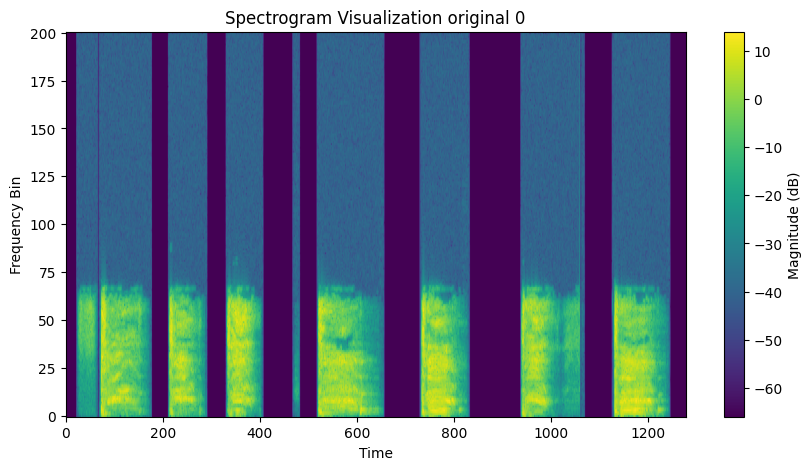

torch.Size([201, 373])


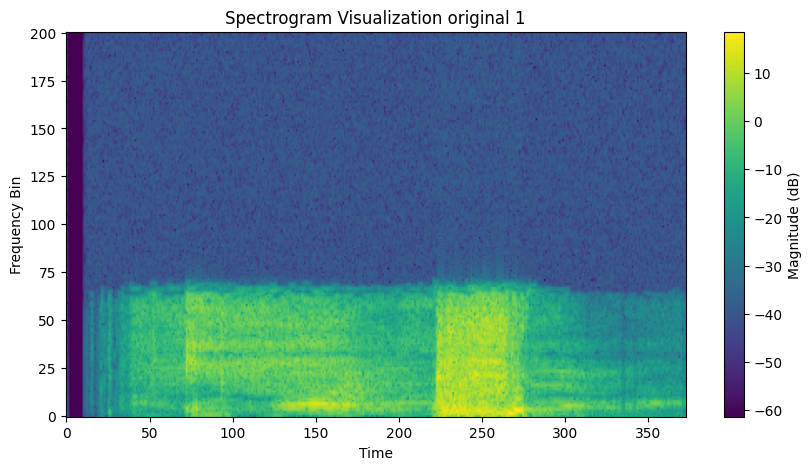

torch.Size([201, 511])


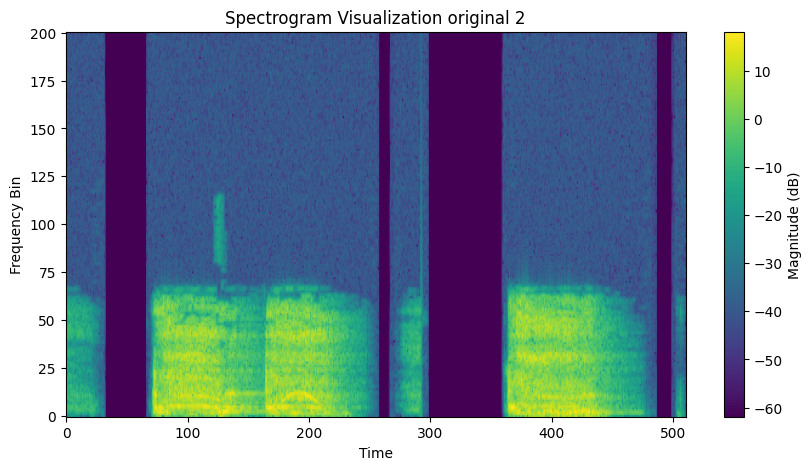

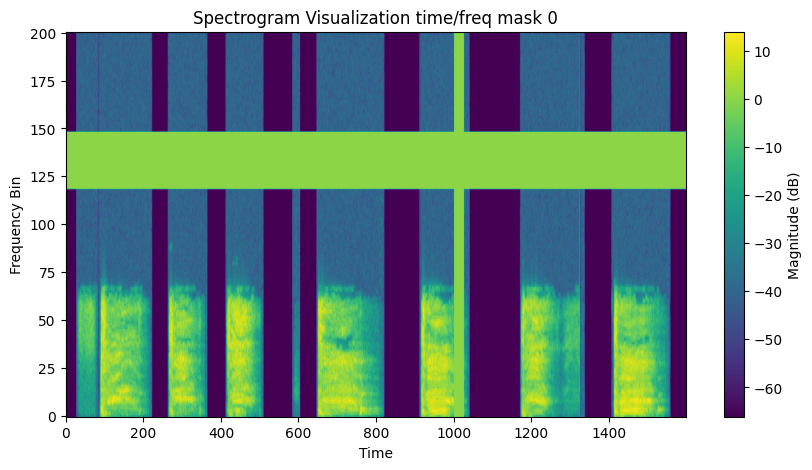

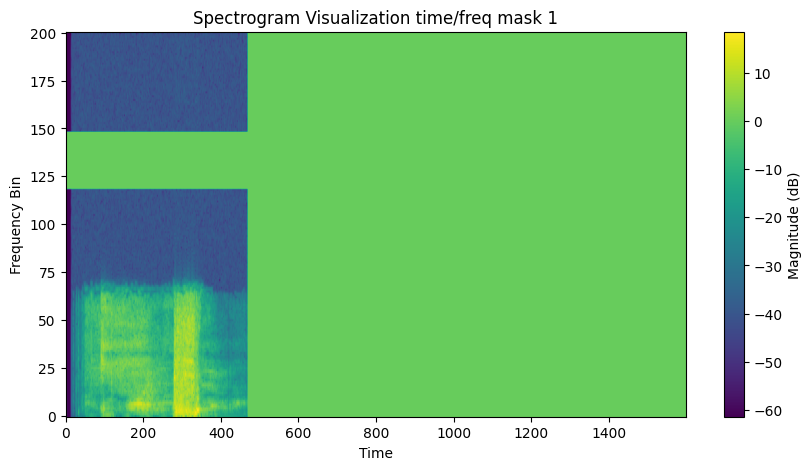

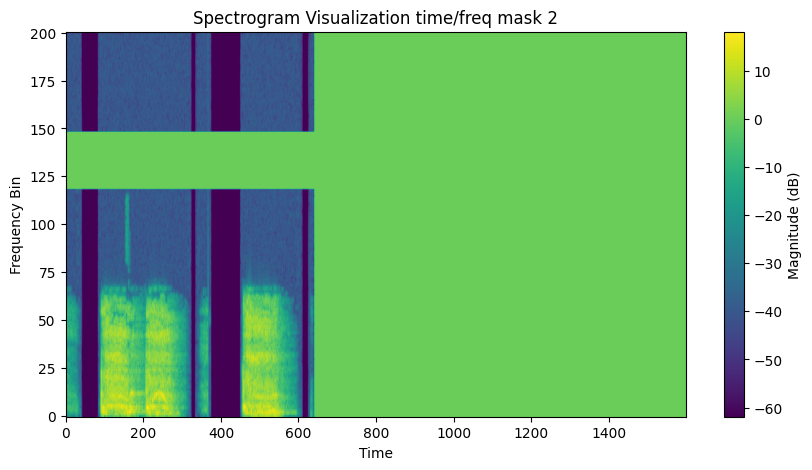

torch.Size([201, 1837])


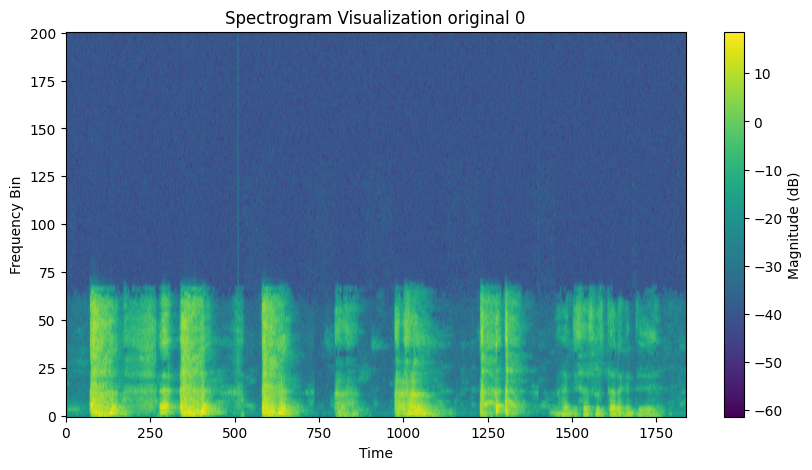

torch.Size([201, 246])


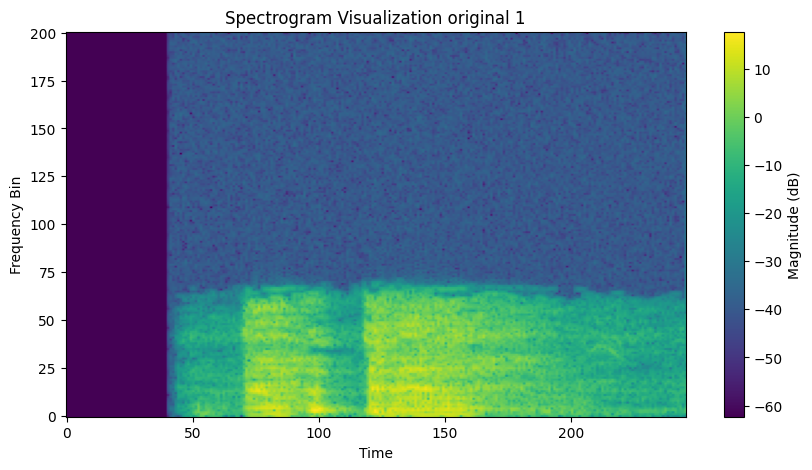

torch.Size([201, 1651])


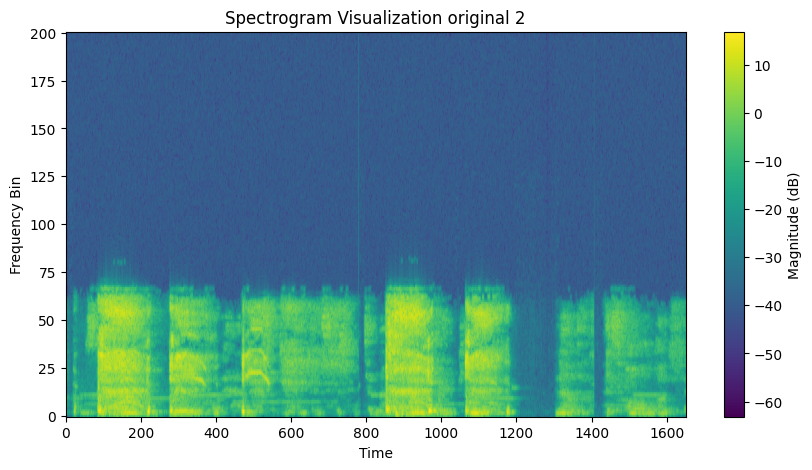

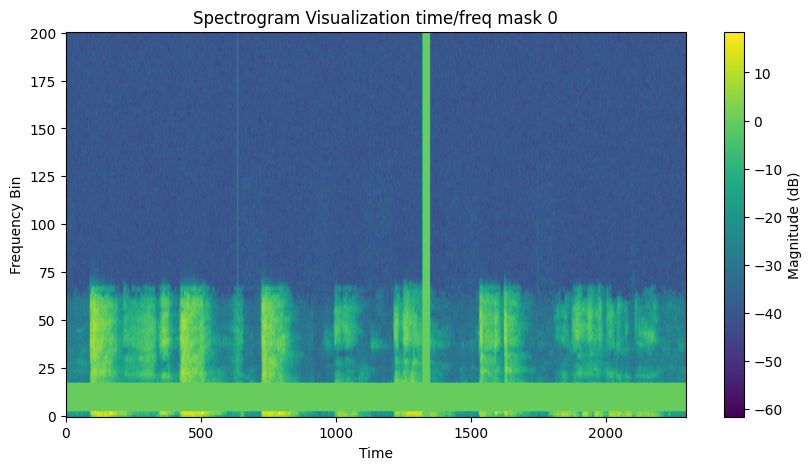

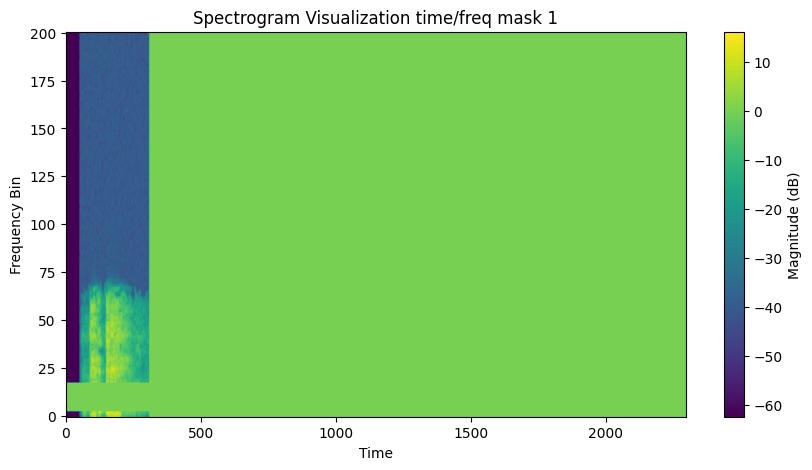

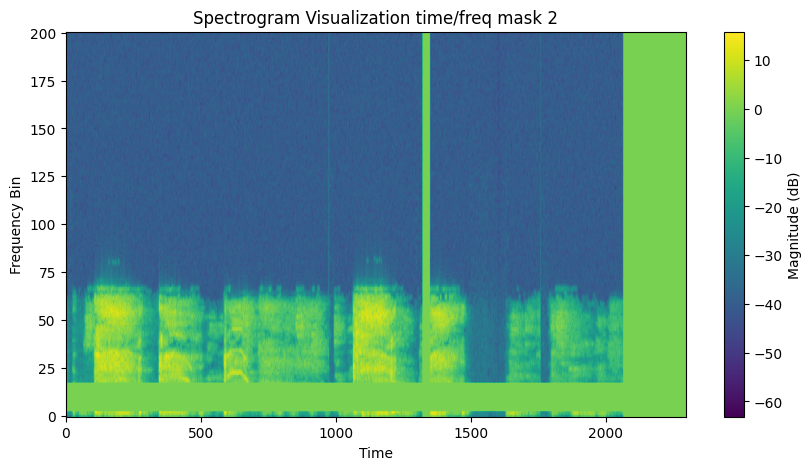

torch.Size([201, 1004])


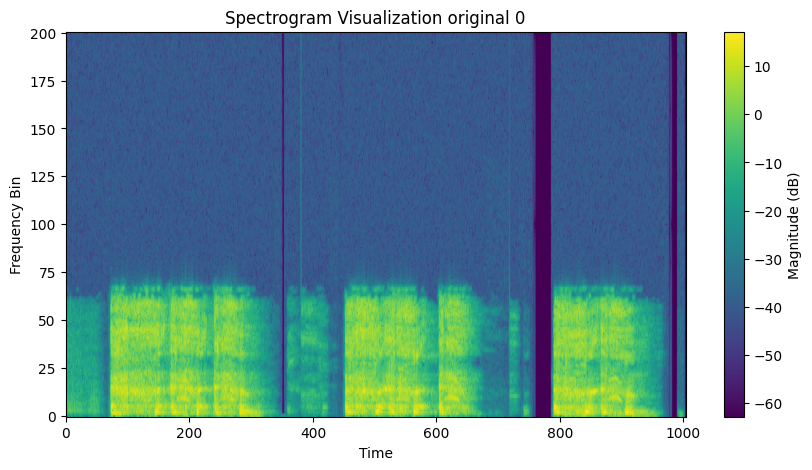

Epoch 1/25 | Training:   1%|          | 2/346 [00:12<35:23,  6.17s/it]
Epoch | :   0%|          | 0/25 [00:12<?, ?it/s]

torch.Size([201, 425])


KeyboardInterrupt: 

In [67]:
# Initialize training setup
optimizer, criterion, scheduler, criterion2 = initialize_training_setup(model, optimizer_type, scheduler_type, weighted, device)
best_vloss = float("inf")
model_no = 0

# Create a GradScaler instance
scaler = GradScaler()

# Training and validation loop
for epoch in tqdm(range(epochs), total=epochs, leave=True, desc=f"Epoch | "):
    # avg_loss, accuracy = train_epoch(model, model_type, device, epoch, optimizer, criterion)
    # avg_loss, accuracy_class, accuracy_age, accuracy_gender = train_epoch_modified(model, device, epoch, optimizer, criterion)
    avg_loss, accuracy_class, accuracy_age, accuracy_gender = train_epoch_undersampled(model, device, epoch, optimizer, criterion)
    # avg_vloss, vaccuracy, precision, recall, f1 = validate_epoch(model, device, epoch, criterion)
    # avg_vloss, metrics = validate_epoch_modified(model, device, epoch, criterion)
    avg_vloss, metrics = validate_epoch(model, device, epoch, criterion)

    # Print and log metrics
    # MultiResnet model
    # print(f"Epoch #{epoch+1} | Training Loss: {avg_loss:.4f} | Validation Loss: {avg_vloss:.4f} | Validation Accuracy: {vaccuracy:.4f}")
    # print(f"Epoch #{epoch+1} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
    # print(f"Epoch #{epoch+1} | Learning Rate: {scheduler.get_last_lr()}")

    # Extract metrics
    vaccuracy = metrics[0]
    vprecision = metrics[1]
    vrecall = metrics[2]
    vf1 = metrics[3]

    # ModifiedMultiResnet model
    print(f"Epoch #{epoch+1} | Training Loss: {avg_loss:.4f} | Validation Loss: {avg_vloss:.4f}")
    print(f"Epoch #{epoch+1} | Class Accuracy: {vaccuracy[0]:.4f} | Age Accuracy: {vaccuracy[1]:.4f} | Gender Accuracy: {vaccuracy[2]:.4f}")
    print(f"Epoch #{epoch+1} | Class Precision: {vprecision[0]:.4f} | Precision: {vprecision[1]:.4f} | Precision: {vprecision[2]:.4f}")
    print(f"Epoch #{epoch+1} | Class Recall: {vrecall[0]:.4f} | Age Recall: {vrecall[1]:.4f} | Gender Recall: {vrecall[2]:.4f}")
    print(f"Epoch #{epoch+1} | Class F1 score: {vf1[0]:.4f} | Age F1 score: {vf1[1]:.4f} | Gender F1 Score: {vf1[2]:.4f}")

    # Update learning rate
    if scheduler_type == "steplr":
        scheduler.step()
    elif scheduler_type == "stepplateau":
        scheduler.step(avg_vloss)

    # Log metrics to wandb
    # MultiResnet model
    # wandb.log({
    #        "epoch": epoch + 1,
    #        "train_loss": avg_loss,
    #        "train_acc": accuracy,
    #        "val_loss": avg_vloss,
    #        "val_accuracy": vaccuracy,
    #    })
    # wandb.log({"precision": precision, "recall": recall, "f1_score": f1})

    # ModifiedMultiResnet model accuracy_class, accuracy_age, accuracy_gender
    wandb.log(
        {
            "epoch": epoch + 1,
            "avg_train_loss": avg_loss,
            "avg_val_loss": avg_vloss,
            "train_class_accuracy": accuracy_class,
            "train_age_accuracy": accuracy_age,
            "train_gender_accuracy": accuracy_gender,
            "val_class_accuracy": vaccuracy[0],
            "val_age_accuracy": vaccuracy[1],
            "val_gender_accuracy": vaccuracy[2],
            "val_class_precision": vprecision[0],
            "val_age_precision": vprecision[1],
            "val_gender_precision": vprecision[2],
            "val_class_recall": vrecall[0],
            "val_age_recall": vrecall[1],
            "val_gender_recall": vrecall[2],
            "val_class_f1_score": vf1[0],
            "val_age_f1_score": vf1[1],
            "val_gender_f1_score": vf1[2],
        }
    )

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_no += 1
        if not os.path.exists("models"):
            os.makedirs("models")
        model_path = f"models/{model_output}_no_{model_no}_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)

In [ ]:
wandb.finish()